# Running the SBML PBK model with roadrunner

This notebook demonstrates how to run simulations with the SBML PBK model using the roadrunner library.

## Preparation

In [8]:
import roadrunner as rr
import math
import matplotlib.pyplot as plt

# Specify sbml file path
sbml_file = '../model/euromix.sbml'

# Specify the input
oral_input = 'QGut'

## Running the model

In [9]:
# Helper function for plotting simulation results
def plotSimulationResults(res, selections):
    fig, axes = plt.subplots(3,math.ceil((len(selections) - 1)/3),figsize=(10,6))
    axes = axes.flatten()
    for ax in axes:
        ax.set(xlabel='time') 
    labels = selections
    for i in range(1, len(selections)):
        sid = selections[i]
        axes[i-1].plot(res['time'], res[sid])
        axes[i-1].set(ylabel=f"Amount", title=labels[i])
    fig.tight_layout()

### Single oral bolus

Single oral dose of 1 at $t_0$ fed as initial amount of the input compartment.

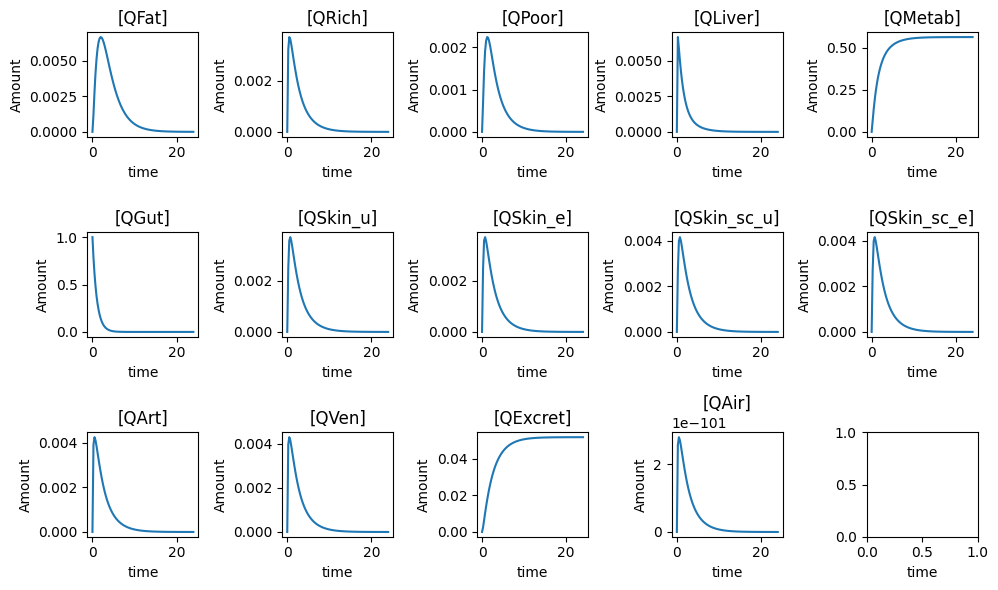

In [10]:
# Load the PBPK model from the SBML file
rr_model = rr.RoadRunner(sbml_file)

# Set initial amout
rr_model.setInitAmount(oral_input, 1)
rr_model.setConstant(oral_input, False)
rr_model.setBoundary(oral_input, False)

# Simulate the PBPK model
rr_model.resetAll()
results = rr_model.simulate(start=0, end=24, points=100)

# Plot the results
plotSimulationResults(results, rr_model.timeCourseSelections)

### Continuous oral dose

Continuous dose of 1 set as initial amount, accomplished by setting the input compartment to boundary and constant.

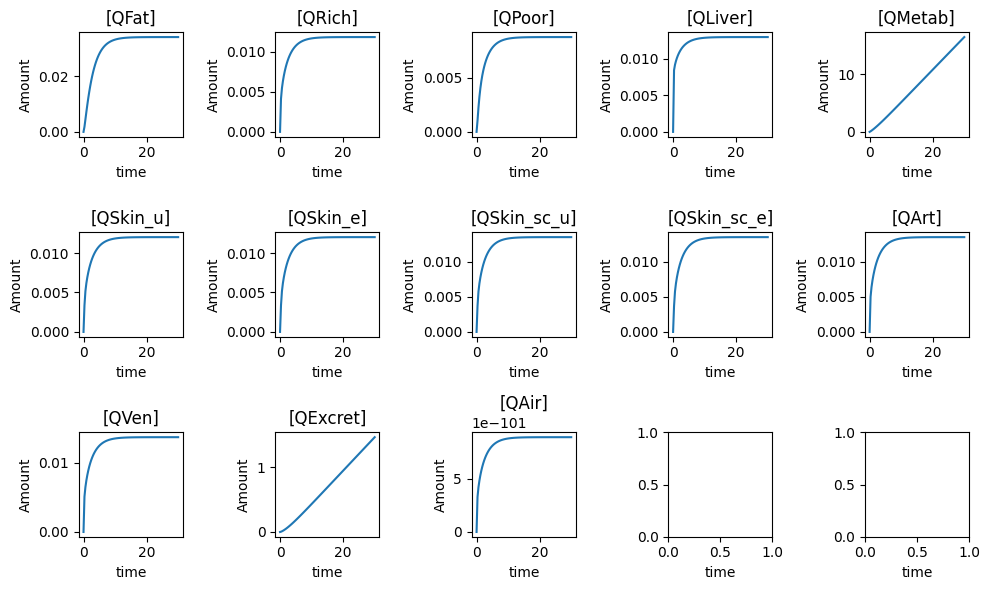

In [11]:
# Load the PBPK model from the SBML file
rr_model = rr.RoadRunner(sbml_file)

# Set initial amout set constant and boundary for Gut
rr_model.setInitAmount(oral_input, 1)
rr_model.setConstant(oral_input, True)
rr_model.setBoundary(oral_input, True)

# Simulate the PBPK model
rr_model.resetAll()
results = rr_model.simulate(start=0, end=30, points=100)

# Plot the results
plotSimulationResults(results, rr_model.timeCourseSelections)

### Multiple oral dosing events

Bolus inputs fed to the model via events (one per day).

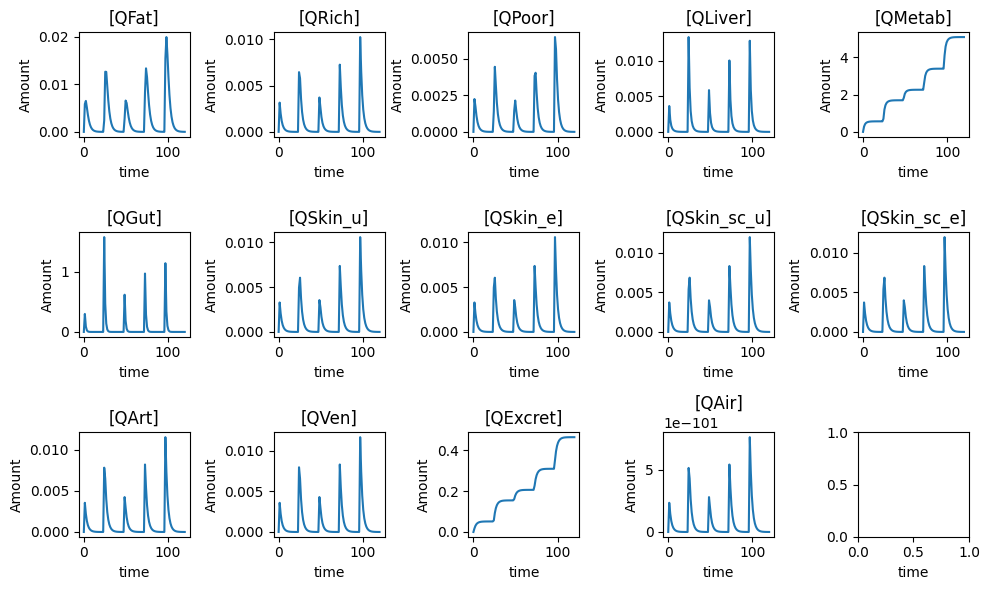

In [12]:
# Load the PBPK model from the SBML file
rr_model = rr.RoadRunner(sbml_file)

# Make sure A_gut is not constant and does not have boundary conditions
rr_model.setInitAmount(oral_input, 0)
rr_model.setConstant(oral_input, False)
rr_model.setBoundary(oral_input, False)

# Remove all events
for event_id in rr_model.model.getEventIds():
    rr_model.removeEvent(event_id)

# Define a list of time/dose tuples
time_dose_list = [
    (0, 1),
    (24, 2),
    (48, 1),
    (72, 2),
    (96, 3)
]

# Create an event for each of the time-dose tuples
for i in range(0, len(time_dose_list)):
    dose_event = time_dose_list[i]
    eid = f"oral_dose_event_{i}"
    rr_model.addEvent(eid, False, f"time > {dose_event[0]}", False)
    rr_model.addEventAssignment(eid, oral_input, f"{oral_input} + {dose_event[1]}", False)
rr_model.regenerateModel(True, True)

# Simulate the PBPK model
results = rr_model.simulate(start=0, end=5*24, points=100)

# Plot the results
plotSimulationResults(results, rr_model.timeCourseSelections)

### Multiple continuous oral input events

Continuous input events during 8 hours of the day over multiple days. Accomplished by setting the boundary condition to true.

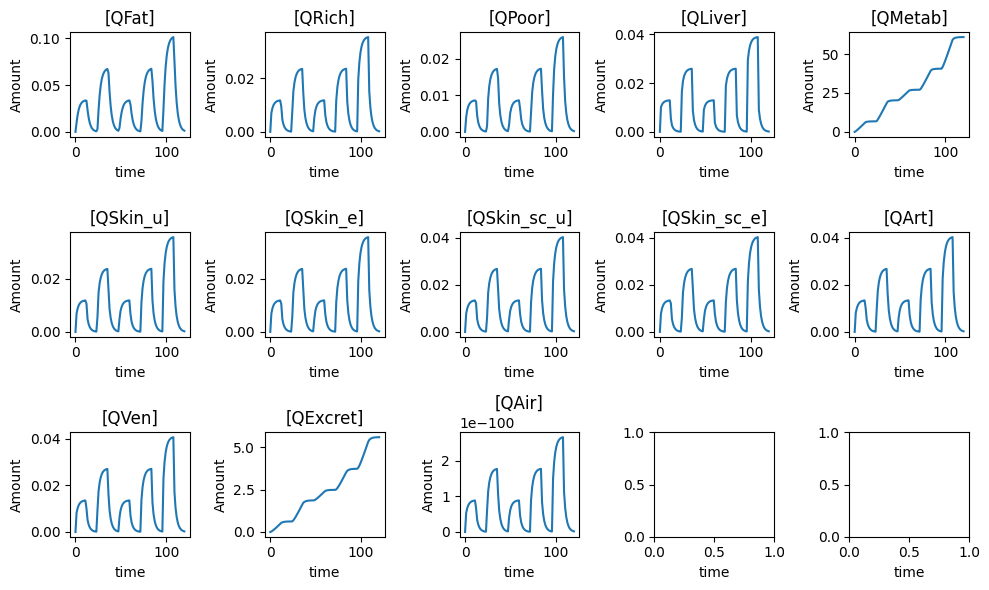

In [13]:
# Load the PBPK model from the SBML file
rr_model = rr.RoadRunner(sbml_file)

# Make sure A_gut is not constant and does not have boundary conditions
rr_model.setInitAmount(oral_input, 0)
rr_model.setConstant(oral_input, False)
rr_model.setBoundary(oral_input, True)

# Remove all events
for event_id in rr_model.model.getEventIds():
    rr_model.removeEvent(event_id)

# Define a list of time/dose tuples
time_dose_duration_list = [
    (0, 1, 12),
    (24, 2, 12),
    (48, 1, 12),
    (72, 2, 12),
    (96, 3, 12)
]

# Create an event for each of the time-dose tuples
for i in range(0, len(time_dose_list)):
    dose_event = time_dose_duration_list[i]
    eid = f"oral_dose_event_{i}_start"
    rr_model.addEvent(eid, False, f"time > {dose_event[0]}", False)
    rr_model.addEventAssignment(eid, oral_input, f"{oral_input} + {dose_event[1]}", False)
    eid = f"oral_dose_event_{i}_stop"
    rr_model.addEvent(eid, False, f"time > {dose_event[0]} + {dose_event[2]}", False)
    rr_model.addEventAssignment(eid, oral_input, f"{oral_input} - {dose_event[1]}", False)
rr_model.regenerateModel(True, True)

# Simulate the PBPK model
results = rr_model.simulate(start=0, end=5*24, points=100)

# Plot the results
plotSimulationResults(results, rr_model.timeCourseSelections)

# Get compartment volumes

In [14]:
import libsbml as ls
document = ls.readSBML(sbml_file)
model = document.getModel()
for i in range(0,model.getNumCompartments()):
    c = model.getCompartment(i)
    print(f'{c.getId()} - {rr_model[c.getId()]}')

Air - 1.0
Urine - 1.0
Fat - 14.629999999999999
Rich - 7.35
Liver - 1.68
Art - 1.586666666666667
Ven - 3.173333333333334
Skin_e - 0.2318
Skin_u - 2.0862000000000003
Skin_sc_e - 0.0019
Skin_sc_u - 0.0171
Poor - 32.24300000000001
Gut - 1.0
